<a href="https://colab.research.google.com/github/joyuno/collection-of-side-project/blob/main/%5BBaseline%5D_XGBoost%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%B1%84%EB%AC%B4_%EB%B6%88%EC%9D%B4%ED%96%89_%EC%97%AC%EB%B6%80_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import

In [ ]:
!pip install --upgrade scikit-learn scipy

  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings(action='ignore')

## 2. Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('/content/drive/MyDrive/dacon_project_default_prediction/train.csv').drop(columns=['UID'])
test_df = pd.read_csv('/content/drive/MyDrive/dacon_project_default_prediction/test.csv').drop(columns=['UID'])

In [ ]:
train_df.head() # 연간 소득 비중 보기

# '대출 상환 기간' 0,1로 바꾸기
# 총부채상환비율 (DTI) = (월 상환 부채액 / 연간 소득)
#train_df['DTI'] = train_df['월 상환 부채액'] / (train_df['연간 소득'] / 12)

# 신용 한도 대비 미상환액 비율 (Credit Utilization)
#train_df['Credit_Utilization'] = train_df['현재 미상환 신용액'] / train_df['최대 신용한도']
# ['연간 소득', '최대 신용한도', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액'] 로그변환
#log_features = ['연간 소득', '최대 신용한도', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액']
#for col in log_features:
#    train_df[col] = np.log1p(train_df[col])  # log(1+x) 변환
# train_df['근속 안정성'] = train_df['현재 직장 근속 연수'].apply(lambda x: 1 if x >= 7 else 0)
#train_df['최근 연체 여부'] = train_df['마지막 연체 이후 경과 개월 수'].apply(lambda x: 1 if x < 12 else 0)
#train_df['신용 이력 그룹'] = pd.cut(train_df['신용 거래 연수'], bins=[5, 10, 15, 20, 50], labels=[0, 1, 2, 3])

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부
0,자가,1941337.5,10년 이상,0.0,9,13.4,400597.5,0,24,1,부채 통합,단기 상환,390903.0,225457.5,8806.5,767,0
1,월세,1979505.0,10년 이상,0.0,5,15.1,360679.5,0,11,0,부채 통합,단기 상환,1002184.5,64749.0,24961.5,767,0
2,월세,1356381.0,4년,0.0,12,18.8,491770.5,1,74,3,부채 통합,단기 상환,227775.0,487644.0,12069.0,800,1
3,월세,1049017.5,6년,0.0,15,14.8,411546.0,1,22,1,부채 통합,단기 상환,251383.5,413211.0,31749.0,796,1
4,월세,4320217.5,2년,0.0,11,26.1,895288.5,0,32,0,부채 통합,장기 상환,1163176.5,78991.5,5862.0,751,0


In [ ]:
train_df['신용 거래 연수'].describe()

,신용 거래 연수
count,10000.000000
mean,19.879360
std,7.206693
min,6.000000
25%,14.600000
50%,17.950000
75%,24.100000
max,51.700000


In [ ]:
train_df.groupby('현재 직장 근속 연수')['현재 직장 근속 연수'].count()

,현재 직장 근속 연수
현재 직장 근속 연수,
10년 이상,3828
1년,581
1년 미만,488
2년,1225
3년,523
4년,541
5년,729
6년,357
7년,619


In [ ]:
train_df['마지막 연체 이후 경과 개월 수'].describe() # 24개월 기준으로 잡자 28도 시도

,마지막 연체 이후 경과 개월 수
count,10000.000000
mean,30.889200
std,20.011561
min,0.000000
25%,14.000000
50%,28.000000
75%,41.000000
max,88.000000


In [ ]:
train_df['주거 형태'].value_counts() #get_dummies() 사용

,주거 형태
월세,4050
주택 담보 대출 (거주 중),3633
자가,2241
주택 담보 대출 (비거주 중),76


In [ ]:
train_df.describe() #신용 점수가 최소점수가 502점이라는 점 주목
# 반면 신용 거래 연수와 연간 소득 max 가 지나치게 튐,//신용 문제 발생 횟수와 개인 파산 횟수는 오버 샘플링 고려해보기

,연간 소득,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부
count,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.00000,10000.000000,10000.000000
mean,2.163959e+06,0.199300,12.248900,19.879360,1.175265e+06,0.62620,30.889200,0.373200,5.061200e+05,3.649126e+05,22367.28075,744.215000,0.341200
std,1.434430e+06,0.714304,4.620572,7.206693,1.604199e+06,1.23419,20.011561,0.843797,2.831462e+05,3.537942e+05,15186.49738,56.995698,0.474136
min,2.676210e+05,0.000000,2.000000,6.000000,0.000000e+00,0.00000,0.000000,0.000000,2.917650e+04,0.000000e+00,0.00000,502.000000,0.000000
25%,1.311437e+06,0.000000,9.000000,14.600000,4.482476e+05,0.00000,14.000000,0.000000,3.001901e+05,1.471856e+05,10893.75000,704.000000,0.000000
50%,1.743223e+06,0.000000,12.000000,17.950000,7.670910e+05,0.00000,28.000000,0.000000,4.743412e+05,2.547930e+05,20160.00000,756.000000,0.000000
75%,2.447664e+06,0.000000,15.000000,24.100000,1.147283e+06,1.00000,41.000000,0.000000,5.919079e+05,4.749180e+05,30647.25000,793.000000,1.000000
max,1.722975e+07,7.000000,35.000000,51.700000,2.323233e+07,7.00000,88.000000,3.000000,1.373613e+06,3.946300e+06,153574.50000,825.000000,1.000000


In [ ]:
train_df['채무 불이행 여부'].value_counts() # 채무 불이행 여부 6588개로 오버 샘플링 하기? 안하기 둘다 비교
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE 적용 (소수 클래스(1) 데이터 합성 생성)
#smote = SMOTE(sampling_strategy=1.0, random_state=42)  # 1:1 비율로 맞춤
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

,채무 불이행 여부
0,6588
1,3412


In [ ]:
threshold1 = train_df['연간 소득'].quantile(0.99)
threshold2 = train_df['연간 소득'].quantile(0.999)
# 상위 1%,0.1% 값만 필터링
top_1_percent = train_df[train_df['연간 소득'] > threshold1]
top_0p1_percent = train_df[train_df['연간 소득'] > threshold2]

In [ ]:
print(top_1_percent.shape[0])
print(top_1_percent['연간 소득'].mean())
print(top_1_percent['연간 소득'].min())
print(top_1_percent['연간 소득'].max())
print(top_0p1_percent.shape[0])
print(top_0p1_percent['연간 소득'].mean())
print(top_0p1_percent['연간 소득'].min())
print(top_0p1_percent['연간 소득'].max())
print(top_0p1_percent['연간 소득'].sort_values(ascending=False)) # 증가폭은 높은 편이나 이상치 급으로 튀지는 않음

100
10106717.715
7605937.5
17229747.0
10
14587826.85
12979972.5
17229747.0
8386    17229747.0
6790    16497990.0
1518    16246152.0
4013    15618802.5
3995    14082696.0
5934    13552071.0
559     13243704.0
2577    13219294.5
1413    13207839.0
7836    12979972.5
Name: 연간 소득, dtype: float64


(array([5.932e+03, 2.889e+03, 8.400e+02, 2.110e+02, 6.000e+01, 3.400e+01,
        1.700e+01, 1.200e+01, 1.000e+00, 4.000e+00]),
 array([  267621. ,  1963833.6,  3660046.2,  5356258.8,  7052471.4,
         8748684. , 10444896.6, 12141109.2, 13837321.8, 15533534.4,
        17229747. ]),
 <BarContainer object of 10 artists>)

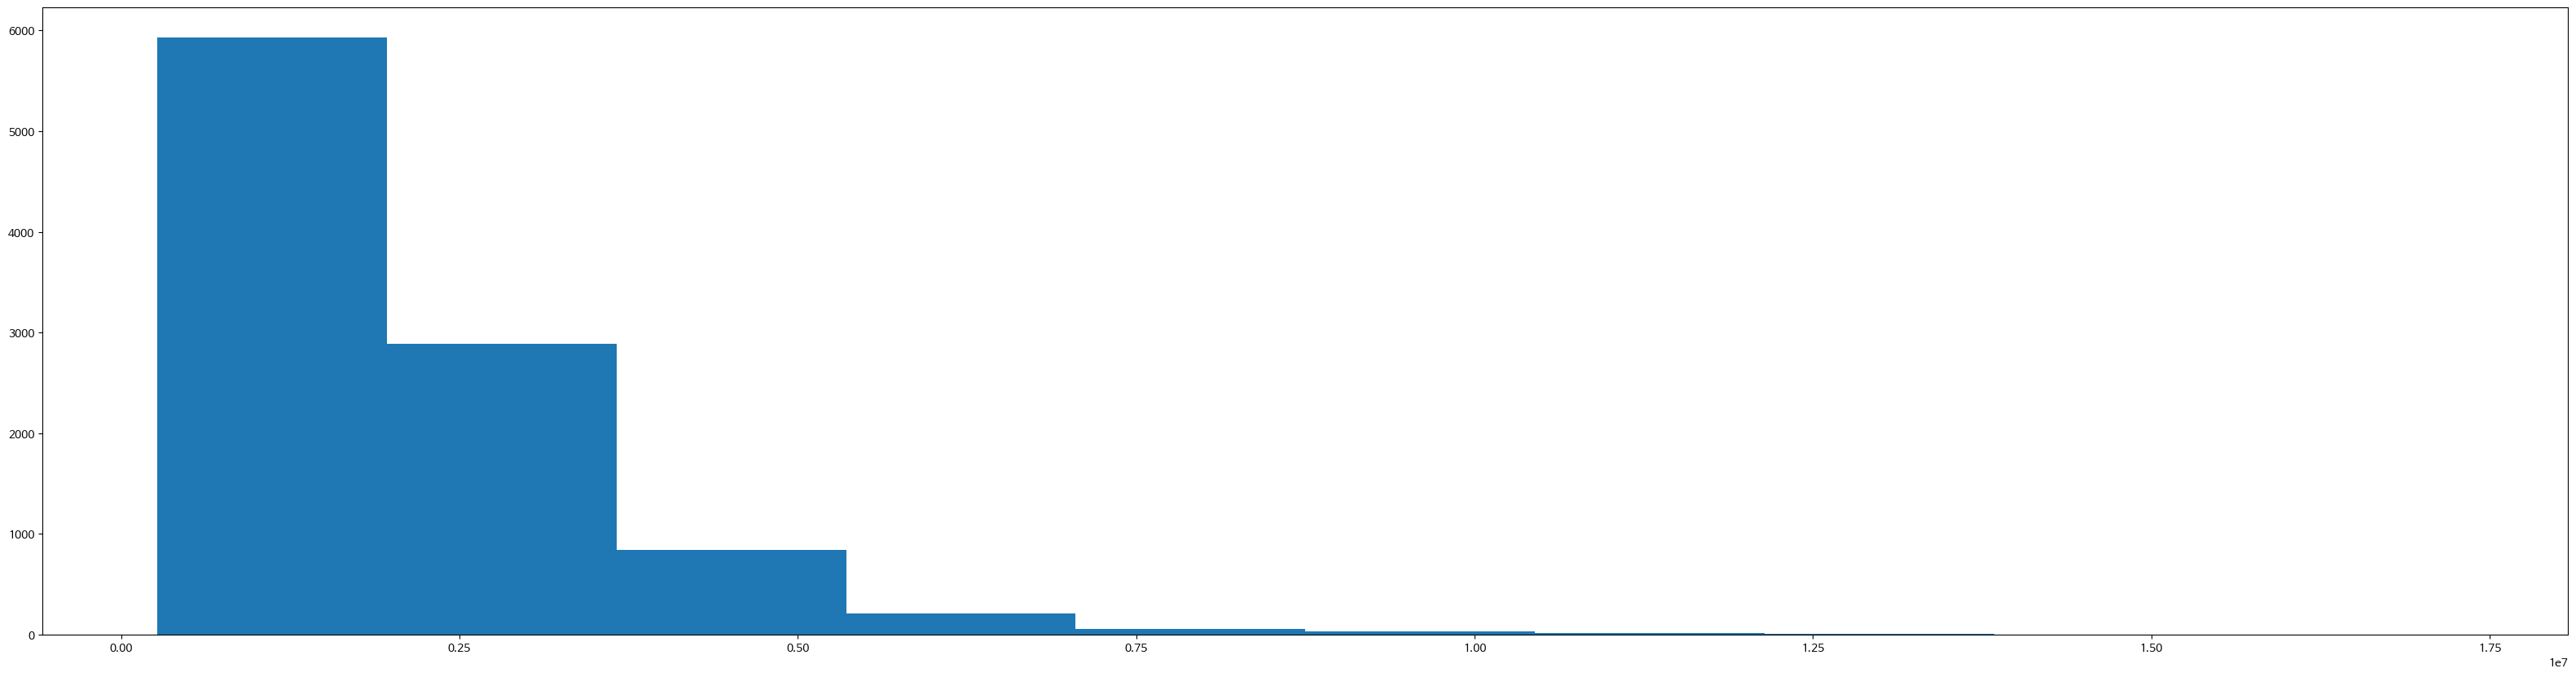

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
annual_income = train_df['연간 소득'].sort_values(ascending=False).reset_index(drop=True)
plt.hist(annual_income)

In [ ]:
train_df.describe(include = "O")

,주거 형태,현재 직장 근속 연수,대출 목적,대출 상환 기간
count,10000,10000,10000,10000
unique,4,11,14,2
top,월세,10년 이상,부채 통합,단기 상환
freq,4050,3828,7294,6975


In [ ]:
train_df.groupby('대출 상환 기간')['채무 불이행 여부'].value_counts() # 장기 상환자의 채무 불이행률이 더 높다

대출 상환 기간  채무 불이행 여부
단기 상환     0            4842
          1            2133
장기 상환     0            1746
          1            1279
Name: 채무 불이행 여부, dtype: int64

# 피처 엔지니어링 변형부분만


In [ ]:
train_df['대출 상환 기간']

In [ ]:
non_default = train_df[train_df['채무 불이행 여부'] == 0].groupby('대출 목적')['채무 불이행 여부'].count()
default = train_df[train_df['채무 불이행 여부'] == 1].groupby('대출 목적')['채무 불이행 여부'].count()
all_purposes = train_df['대출 목적'].unique()

# 인덱스를 통일하기 위해 reindex 사용
non_default = non_default.reindex(all_purposes, fill_value=0)
default = default.reindex(all_purposes, fill_value=0)

# 같은 인덱스끼리 나누기
print(default / (non_default.replace(0, np.nan)+1))


대출 목적
부채 통합        0.662489
자동차 구매       0.156627
기타           0.277632
사업 대출        0.225962
주택 개보수       0.211718
여행 자금        0.191781
소규모 사업 자금    0.000000
교육비          0.000000
의료비          0.242188
고액 구매        0.131148
결혼 자금        0.153846
휴가 비용        0.400000
주택 구매        0.173913
이사 비용        0.000000
Name: 채무 불이행 여부, dtype: float64


In [ ]:
data_a=default / (non_default.replace(0, np.nan)+1)
purpose_ratio=data_a.to_dict()
purpose_ratio

{'부채 통합': 0.6624886052871468,
 '자동차 구매': 0.1566265060240964,
 '기타': 0.2776315789473684,
 '사업 대출': 0.22596153846153846,
 '주택 개보수': 0.21171770972037285,
 '여행 자금': 0.1917808219178082,
 '소규모 사업 자금': 0.0,
 '교육비': 0.0,
 '의료비': 0.2421875,
 '고액 구매': 0.13114754098360656,
 '결혼 자금': 0.15384615384615385,
 '휴가 비용': 0.4,
 '주택 구매': 0.17391304347826086,
 '이사 비용': 0.0}

In [ ]:
train_df['대출 목적 비율'] = train_df['대출 목적'].map(purpose_ratio)
test_df['대출 목적 비율'] = test_df['대출 목적'].map(purpose_ratio)

In [ ]:
train_df=train_df.drop(columns=['대출 목적'])
test_df=test_df.drop(columns=['대출 목적'])

In [ ]:
train_df['최대 신용한도 대비 미상환율'] = train_df['현재 미상환 신용액'] / (train_df['최대 신용한도']+1)
test_df['최대 신용한도 대비 미상환율'] = test_df['현재 미상환 신용액'] / (test_df['최대 신용한도']+1)

In [ ]:
train_df['신용 거래 연수 그룹'] = pd.cut(train_df['신용 거래 연수'], bins=[5, 10, 15, 20, 50], labels=[0, 1, 2, 3])
test_df['신용 거래 연수 그룹'] = pd.cut(test_df['신용 거래 연수'], bins=[5, 10, 15, 20, 50], labels=[0, 1, 2, 3])

In [ ]:
train_df = train_df.drop(columns=['신용 거래 연수'])
test_df = test_df.drop(columns=['신용 거래 연수'])

In [ ]:
train_df['최근 연체 여부'] = train_df['마지막 연체 이후 경과 개월 수'].apply(lambda x: 1 if x < 28 else 0)
test_df['최근 연체 여부'] = test_df['마지막 연체 이후 경과 개월 수'].apply(lambda x: 1 if x < 28 else 0)

KeyError: '마지막 연체 이후 경과 개월 수'

In [ ]:
train_df=train_df.drop(columns= ['마지막 연체 이후 경과 개월 수'])
test_df = test_df.drop(columns= ['마지막 연체 이후 경과 개월 수'])

In [ ]:
train_df['근속 연수 7년이상'] = train_df['현재 직장 근속 연수'].apply(
    lambda x: 1 if x in ['7년', '8년', '9년', '10년 이상'] else 0
)
test_df['근속 연수 7년이상'] = test_df['현재 직장 근속 연수'].apply(
    lambda x: 1 if x in ['7년', '8년', '9년', '10년 이상'] else 0
)

In [ ]:
train_df.drop(columns=['현재 직장 근속 연수'], inplace=True)
test_df.drop(columns=['현재 직장 근속 연수'], inplace=True)

In [ ]:
train_df['대출 상환 기간'] = train_df['대출 상환 기간'].map({'장기 상환': 1, '단기 상환': 0})
test_df['대출 상환 기간'] = test_df['대출 상환 기간'].map({'장기 상환': 1, '단기 상환': 0})

In [ ]:
# IQR을 활용한 이상치 제거 함수
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.001)
    Q3 = df[column].quantile(0.999)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.3 * IQR
    upper_bound = Q3 + 1.3 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

outlier_features = ['체납 세금 압류 횟수', '개설된 신용계좌 수', '신용 문제 발생 횟수', '개인 파산 횟수']
for col in outlier_features:
    train_df = remove_outliers(train_df, col)

In [ ]:
import numpy as np
log_features = ['연간 소득', '최대 신용한도', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액']
for col in log_features:
    train_df[col] = np.log1p(train_df[col])
    test_df[col] = np.log1p(test_df[col])

In [ ]:
categorical_col = ['대출 목적']
train_df['주거 형태'] = train_df['주거 형태'].map({'자가': 1, '주택 담보 대출 (거주 중)': 2, '월세':3, '주택 담보 대출 (비거주 중)': 4})
test_df['주거 형태'] = test_df['주거 형태'].map({'자가': 1, '주택 담보 대출 (거주 중)': 2, '월세':3, '주택 담보 대출 (비거주 중)': 4})
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 훈련 데이터에 대해 인코더 학습
encoder.fit(train_df[categorical_col])

# 훈련 데이터와 테스트 데이터 변환
train_encoded = encoder.transform(train_df[categorical_col])
test_encoded = encoder.transform(test_df[categorical_col])
# One-hot encoding 결과를 데이터프레임으로 변환
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_col))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_col))

train_df = pd.concat([train_df.drop(columns=categorical_col).reset_index(drop=True), train_encoded_df], axis=1)
test_df = pd.concat([test_df.drop(columns=categorical_col).reset_index(drop=True), test_encoded_df], axis=1)

## 3. Pre-processing (전처리)

In [ ]:
#categorical_col = [
#    '현재 직장 근속 연수'
#]
#train_df['근속 연수 8년 이상 여부'] = train_df['현재 직장 근속 연수'].map(
#    lambda x: 1 if x in ['8년', '9년', '10년 이상'] else 0
#)
#test_df['근속 연수 8년 이상 여부'] = test_df['현재 직장 근속 연수'].map(
#    lambda x: 1 if x in ['8년', '9년', '10년 이상'] else 0
#)
train_df['주거 형태'] = train_df['주거 형태'].map({'자가': 1, '주택 담보 대출 (거주 중)': 2, '월세':3, '주택 담보 대출 (비거주 중)': 4})
test_df['주거 형태'] = test_df['주거 형태'].map({'자가': 1, '주택 담보 대출 (거주 중)': 2, '월세':3, '주택 담보 대출 (비거주 중)': 4})
#train_df['대출 상환 기간'] = train_df['대출 상환 기간'].map({'장기 상환': 1, '단기 상환': 0})
#test_df['대출 상환 기간'] = test_df['대출 상환 기간'].map({'장기 상환': 1, '단기 상환': 0})

In [ ]:
#train_df.drop(columns=['현재 직장 근속 연수','주거 형태'], inplace=True)
#test_df.drop(columns=['현재 직장 근속 연수','주거 형태'], inplace=True)

In [ ]:
train_df.columns

Index(['주거 형태', '연간 소득', '체납 세금 압류 횟수', '개설된 신용계좌 수', '최대 신용한도', '신용 문제 발생 횟수',
       '개인 파산 횟수', '대출 상환 기간', '현재 대출 잔액', '현재 미상환 신용액', '월 상환 부채액', '신용 점수',
       '채무 불이행 여부', '대출 목적 비율', '최대 신용한도 대비 미상환율', '신용 거래 연수 그룹',
       '근속 연수 7년이상'],
      dtype='object')

## 4. Train / Validation Split (학습 데이터 분할)

In [ ]:
from sklearn.model_selection import train_test_split
train_df=train_df.dropna()

In [ ]:
train_df.columns = train_df.columns.str.replace(" ", "_")
test_df.columns = test_df.columns.str.replace(" ", "_")

In [ ]:
X=train_df.drop(columns=['채무_불이행_여부'])
y=train_df['채무_불이행_여부']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=['채무_불이행_여부']),
    train_df['채무_불이행_여부'],
    test_size=0.2,
    random_state=42
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=['채무_불이행_여부']),
    train_df['채무_불이행_여부'],
    test_size=0.2,
    random_state=42
)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)  # 1:1 비율로 맞춤
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)  # 1:1 비율로 맞춤
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
X_train.isnull().sum()

,0
주거_형태,0
연간_소득,0
체납_세금_압류_횟수,0
개설된_신용계좌_수,0
최대_신용한도,0
신용_문제_발생_횟수,0
개인_파산_횟수,0
대출_상환_기간,0
현재_대출_잔액,0
현재_미상환_신용액,0


In [ ]:
X_train.shape

(7999, 16)

In [ ]:
X_train_smote.shape

(9690, 44)

In [ ]:
test_df.shape

(2062, 16)

## 5. Model Training (모델 학습)

In [ ]:
help(lgb)

Help on package lightgbm:

NAME
    lightgbm - LightGBM, Light Gradient Boosting Machine.

DESCRIPTION
    Contributors: https://github.com/microsoft/LightGBM/graphs/contributors.

PACKAGE CONTENTS
    basic
    callback
    compat
    dask
    engine
    libpath
    plotting
    sklearn

CLASSES
    abc.ABC(builtins.object)
        lightgbm.basic.Sequence
    builtins.Exception(builtins.BaseException)
        lightgbm.callback.EarlyStopException
    builtins.object
        lightgbm.basic.Booster
        lightgbm.basic.Dataset
        lightgbm.engine.CVBooster
    sklearn.base.BaseEstimator(sklearn.utils._estimator_html_repr._HTMLDocumentationLinkMixin, sklearn.utils._metadata_requests._MetadataRequester)
        lightgbm.sklearn.LGBMModel
            lightgbm.sklearn.LGBMClassifier(sklearn.base.ClassifierMixin, lightgbm.sklearn.LGBMModel)
                lightgbm.dask.DaskLGBMClassifier(lightgbm.sklearn.LGBMClassifier, lightgbm.dask._DaskLGBMModel)
            lightgbm.sklearn.LGBMRan

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_train['신용_거래_연수_그룹'].head()

,신용_거래_연수_그룹
1281,2
971,2
5928,3
4481,1
2771,3


In [ ]:
import lightgbm as lgb

params = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 5,
    "random_state": 42,
    "num_leaves":32,
    "force_row_wise":True

}

# 모델 초기화
xgb_model = XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.15,
    random_state=42, use_label_encoder=False, eval_metric="auc"

)
xgb_model.set_params(
    scale_pos_weight=1.0,
    enable_categorical=True
)

dtrain = lgb.Dataset(X_train_smote, label=y_train_smote)
dvalid = lgb.Dataset(X_val, label=y_val)
eval_set = [(X_train_smote, y_train_smote), (X_val, y_val)]
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=5, random_state=42
)


# XGBoost 학습
xgb_model.fit(
    X_train_smote, y_train_smote,
    eval_set=eval_set
)

# LightGBM 학습
lgbm_model=lgb.train(
    params=params,
    num_boost_round=10,
    train_set=dtrain,
    valid_sets=[dvalid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(1)
    ]
)

# RandomForest 학습
rf_model.fit(X_train_smote, y_train_smote)


[0]	validation_0-auc:0.79183	validation_1-auc:0.68247
[1]	validation_0-auc:0.80243	validation_1-auc:0.69874
[2]	validation_0-auc:0.80945	validation_1-auc:0.70818
[3]	validation_0-auc:0.81289	validation_1-auc:0.71399
[4]	validation_0-auc:0.81496	validation_1-auc:0.71711
[5]	validation_0-auc:0.81689	validation_1-auc:0.71893
[6]	validation_0-auc:0.81909	validation_1-auc:0.72025
[7]	validation_0-auc:0.82329	validation_1-auc:0.72269
[8]	validation_0-auc:0.82695	validation_1-auc:0.72475
[9]	validation_0-auc:0.83350	validation_1-auc:0.73053
[10]	validation_0-auc:0.83487	validation_1-auc:0.73173
[11]	validation_0-auc:0.83930	validation_1-auc:0.73381
[12]	validation_0-auc:0.84168	validation_1-auc:0.73490
[13]	validation_0-auc:0.84454	validation_1-auc:0.73598
[14]	validation_0-auc:0.84654	validation_1-auc:0.73759
[15]	validation_0-auc:0.84983	validation_1-auc:0.73803
[16]	validation_0-auc:0.85230	validation_1-auc:0.73811
[17]	validation_0-auc:0.85362	validation_1-auc:0.73888
[18]	validation_0-au

RandomForestClassifier(max_depth=5, random_state=42)

In [ ]:
import lightgbm as lgb

params = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 5,
    "random_state": 42,
    "num_leaves":32,
    "force_row_wise":True

}

# 모델 초기화
xgb_model = XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.15,
    random_state=42, use_label_encoder=False, eval_metric="auc"

)
xgb_model.set_params(
    scale_pos_weight=1.0,
    enable_categorical=True
)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_val, label=y_val)
eval_set = [(X_train, y_train), (X_val, y_val)]
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=5, random_state=42
)


# XGBoost 학습
xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set
)

# LightGBM 학습
lgbm_model=lgb.train(
    params=params,
    num_boost_round=10,
    train_set=dtrain,
    valid_sets=[dvalid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(1)
    ]
)

# RandomForest 학습
rf_model.fit(X_train, y_train)


[0]	validation_0-auc:0.72433	validation_1-auc:0.70532
[1]	validation_0-auc:0.74095	validation_1-auc:0.72382
[2]	validation_0-auc:0.75141	validation_1-auc:0.72907
[3]	validation_0-auc:0.75502	validation_1-auc:0.73067
[4]	validation_0-auc:0.76131	validation_1-auc:0.73761
[5]	validation_0-auc:0.76461	validation_1-auc:0.74009
[6]	validation_0-auc:0.77187	validation_1-auc:0.74335
[7]	validation_0-auc:0.77519	validation_1-auc:0.74489
[8]	validation_0-auc:0.77946	validation_1-auc:0.74751
[9]	validation_0-auc:0.78253	validation_1-auc:0.74925
[10]	validation_0-auc:0.78470	validation_1-auc:0.74920
[11]	validation_0-auc:0.78854	validation_1-auc:0.75046
[12]	validation_0-auc:0.79067	validation_1-auc:0.75051
[13]	validation_0-auc:0.79451	validation_1-auc:0.75142
[14]	validation_0-auc:0.79672	validation_1-auc:0.75105
[15]	validation_0-auc:0.79826	validation_1-auc:0.75128
[16]	validation_0-auc:0.80147	validation_1-auc:0.75204
[17]	validation_0-auc:0.80225	validation_1-auc:0.75233
[18]	validation_0-au

RandomForestClassifier(max_depth=5, random_state=42)

In [ ]:
result_lgb=lgbm_model.predict(X_val)
result_lgb

array([0.25582663, 0.15874393, 0.4240388 , ..., 0.61309945, 0.18074487,
       0.47656421])

In [ ]:
result_demo=lgbm_model.predict(test_df)
result_demo

array([0.40623662, 0.50045649, 0.5164926 , ..., 0.46339193, 0.34895765,
       0.71611626])

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict
# LGBMClassifier 객체 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# K-Fold 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행
cv_scores = cross_val_score(lgbm_model, X_smote, y_smote, cv=kf, scoring='roc_auc')

print(f"평균 AUC Score: {cv_scores.mean():.4f}")


[LightGBM] [Info] Number of positive: 5270, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 10540, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# 1️⃣ LGBMClassifier 객체 생성 (최종 학습용)
final_lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# 2️⃣ 전체 데이터로 최종 학습
final_lgbm_model.fit(X_smote, y_smote)

# 3️⃣ 테스트 데이터에서 예측 확률 계산 (predict_proba 사용)
y_test_proba = final_lgbm_model.predict_proba(test_df)[:, 1]


[LightGBM] [Info] Number of positive: 6588, number of negative: 6588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 13176, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:

# K-Fold 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행
cv_scores = cross_val_score(xgb_model, X_smote, y_smote, cv=kf, scoring='roc_auc')

print(f"평균 AUC Score: {cv_scores.mean():.4f}")


평균 AUC Score: 0.8370


In [ ]:
# K-Fold 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행
cv_scores = cross_val_score(rf_model, X_smote, y_smote, cv=kf, scoring='roc_auc')

print(f"평균 AUC Score: {cv_scores.mean():.4f}")


평균 AUC Score: 0.8124


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon_project_default_prediction/sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = y_test_proba
submit.to_csv('/content/drive/MyDrive/dacon_project_default_prediction/submission_smote_lgbm.csv', encoding='UTF-8-sig', index=False)

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon_project_default_prediction/sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = result_demo
submit.to_csv('/content/drive/MyDrive/dacon_project_default_prediction/submission_demo_smote.csv', encoding='UTF-8-sig', index=False)

In [ ]:
auc_score_lgb = roc_auc_score(y_val, result_lgb)
auc_score_lgb

0.7563790313881997

In [ ]:
!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.1 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-

In [ ]:
!pip uninstall xgboost
!pip install --upgrade xgboost
!pip install --upgrade pandas
!pip install --upgrade scikit-learn


Found existing installation: xgboost 1.5.0
Uninstalling xgboost-1.5.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/xgboost-1.5.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/xgboost.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/xgboost/*
Proceed (Y/n)? ㅛ
Your response ('ㅛ') was not one of the expected responses: y, n, 
Proceed (Y/n)? y
  Successfully uninstalled xgboost-1.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 81.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [ ]:

# 예측 확률 계산
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]
lgbm_pred = lgbm_model.predict_proba(X_test)[:, 1]
rf_pred = rf_model.predict_proba(X_test)[:, 1]

# ROC-AUC Score 계산
xgb_auc = roc_auc_score(y_test, xgb_pred)
lgbm_auc = roc_auc_score(y_test, lgbm_pred)
rf_auc = roc_auc_score(y_test, rf_pred)

print(f"XGBoost AUC: {xgb_auc:.4f}")
print(f"LightGBM AUC: {lgbm_auc:.4f}")
print(f"RandomForest AUC: {rf_auc:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 44.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
bigframes 1.34.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
from sklearn.metrics import roc_curve

# ROC Curve 계산
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, lgbm_pred)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred)

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_auc:.4f})')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC={lgbm_auc:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={rf_auc:.4f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


## 6. Prediction

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,757 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and dire

In [ ]:
test_df

,연간_소득,체납_세금_압류_횟수,개설된_신용계좌_수,신용_거래_연수,최대_신용한도,신용_문제_발생_횟수,마지막_연체_이후_경과_개월_수,개인_파산_횟수,대출_상환_기간,현재_대출_잔액,...,현재_직장_근속_연수_1년,현재_직장_근속_연수_1년_미만,현재_직장_근속_연수_2년,현재_직장_근속_연수_3년,현재_직장_근속_연수_4년,현재_직장_근속_연수_5년,현재_직장_근속_연수_6년,현재_직장_근속_연수_7년,현재_직장_근속_연수_8년,현재_직장_근속_연수_9년
0,14.260255,0.0,13,12.0,13.113448,0,18,0,0,12.838230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.558693,0.0,9,29.0,13.272220,0,40,0,1,13.629639,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.722959,0.0,11,26.5,13.811344,0,44,0,1,13.684987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.267281,0.0,7,34.4,13.307443,0,45,0,0,13.096592,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,14.644176,0.0,19,25.0,14.485708,0,14,0,0,12.893662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2057,13.456130,0.0,5,7.7,11.259542,0,33,0,0,12.175655,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2058,14.553829,0.0,15,27.2,14.586588,0,35,0,0,13.938301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2059,14.534326,0.0,20,26.7,14.113215,0,69,0,0,13.840667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2060,15.262377,0.0,18,21.3,12.948619,0,6,0,0,13.394079,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# 채무 불이행 '확률'을 예측합니다.
result_xgb = xgb_model.predict_proba(X_val)[:,1]
result_rf = rf_model.predict_proba(X_val)[:,1]

In [ ]:
auc_score_xgb = roc_auc_score(y_val, result_xgb)
auc_score_xgb

0.7553349153273649

In [ ]:
auc_score_rf = roc_auc_score(y_val, result_rf)
auc_score_rf

0.7544428864200194

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon_project_default_prediction/sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = preds_xgb
submit.to_csv('/content/drive/MyDrive/dacon_project_default_prediction/submission_xgb.csv', encoding='UTF-8-sig', index=False)

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon_project_default_prediction/sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = preds_rf
submit.to_csv('/content/drive/MyDrive/dacon_project_default_prediction/submission_rf.csv', encoding='UTF-8-sig', index=False)

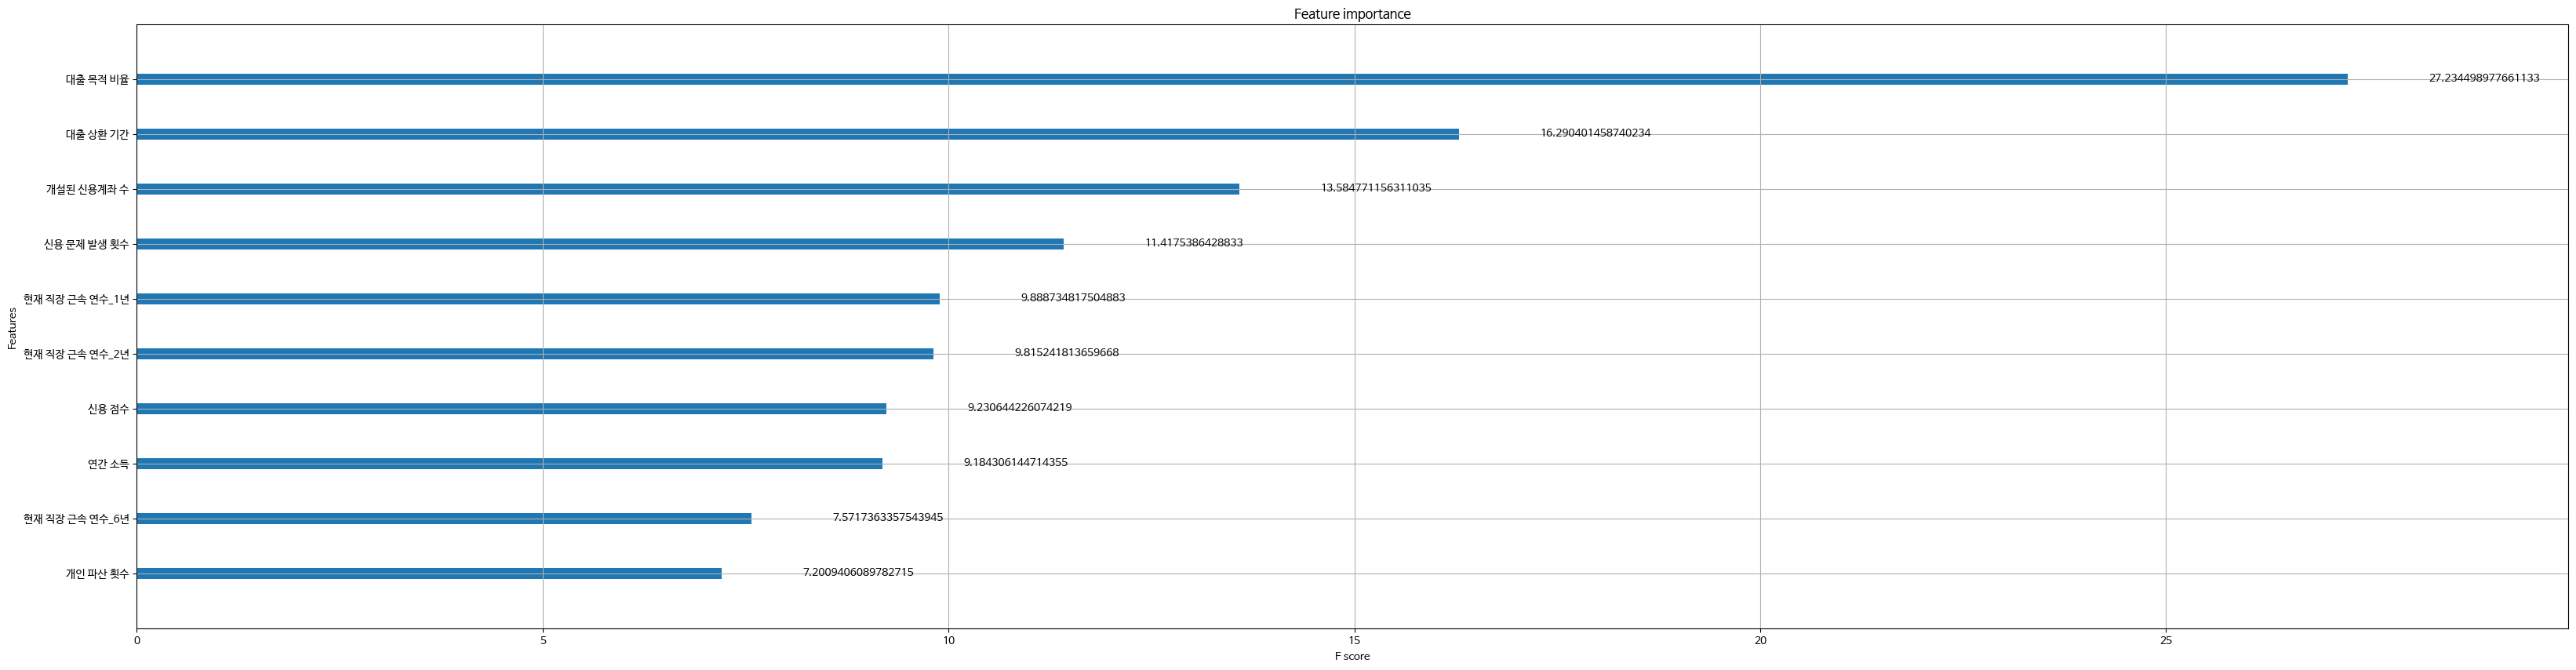

In [ ]:
from xgboost import plot_importance
import matplotlib.font_manager as fm

# 1. 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()

In [ ]:
print(max(preds))
print(min(preds))
print(preds.mean())

0.90583485
0.018932145
0.29047662


## 7. Submission (제출 파일 생성)

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon_project_default_prediction/sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = preds
submit.to_csv('/content/drive/MyDrive/dacon_project_default_prediction/submission.csv', encoding='UTF-8-sig', index=False)